### A Detailed Look at *topleft-corner* Regression Task

In [1]:
import os, sys
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt

from fastai2.basics import *
from fastai2.vision.all import *

In [2]:
path = untar_data(URLs.MNIST_TINY)

In [3]:
df = pd.DataFrame({'fn':[],'y':[]})

for digit_cat in os.listdir(path/'train'):
    
    tmp = [f'/train/{digit_cat}/{e}' for e in 
           os.listdir(path/'train'/str(digit_cat))] 
    df_tmp = pd.DataFrame({'fn': tmp})
    df_tmp['y'] = digit_cat
    df = pd.concat((df, df_tmp))
    
df['y'] = df['y'].astype('float')
df.reset_index(inplace=True)

In [4]:
def point_from_img(fn):

    img_np = np.array(Image.open(str(path) + fn))

    img_bool =         np.where(img_np > 0, 1, 0)
    row_sums =         img_bool.argmax(axis=1)
    binary_row_sums =  np.where(row_sums > 0, 1, 0)
    top_row_index =    binary_row_sums.tolist().index(1)
    top_row_values =   img_np[top_row_index,:]
    leftmost_index =   (top_row_values > 0).tolist().index(True)


    return (top_row_index, leftmost_index)

vals = [point_from_img(e) for e in df['fn']]
df_p = pd.DataFrame(vals, columns=['py','px'])
df = pd.concat((df,df_p ), axis=1)

In [5]:
dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), PointBlock), 
                  splitter=RandomSplitter(),
                   get_x=ColReader('fn', pref=path),
                   get_y=ColReader(['px', 'py'])
                  )

dls = dblock.dataloaders(df)

#### View Task

In [6]:
b =         dls.one_batch()
b_decoded = dls.decode_batch(b, max_n=64)

In [9]:
i=0
b_decoded[i][1]

TensorPoint([[13.,  7.]])

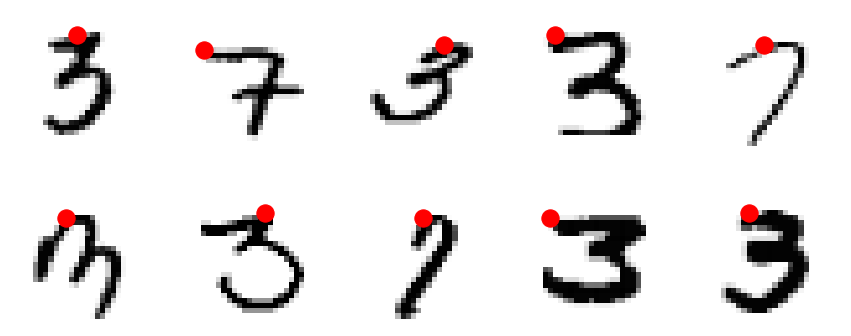

In [8]:
rows, cols = 2,5
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols,3*rows))
axr = ax.ravel()

for i in range(rows*cols):

    b_decoded[i][0].show(ctx=axr[i])
    b_decoded[i][1].show(ctx=axr[i], s=300, marker='o', c='red')


In [9]:
len(dls.train.get_idxs()), len(dls.valid.get_idxs())

(568, 141)

In [10]:
prelearn_b = dls.one_batch()

#### Plotting position of y

In [11]:
import random
def epsilon(step=1):
    return random.uniform(-step,step)

In [12]:
xbar, ybar = df['px'].mean(), 28 - df['py'].mean()

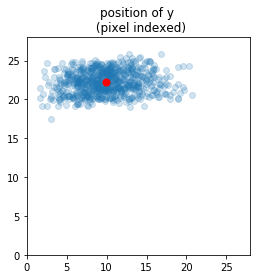

In [13]:
plt.figure(figsize=(4,4))
plt.scatter(x= [e + epsilon()    for e in df['px']], 
            y= [28-e + epsilon() for e in df['py']],
            alpha=0.2
       )
plt.scatter(xbar, ybar, marker='o', c='red', s=50)
plt.ylim(0,28)
plt.xlim(0,28)
plt.title('position of y \n (pixel indexed)');

In [14]:
y = torch.tensor([])
for _x, _y in dls.train:
    y = torch.cat((y,_y), dim=0)

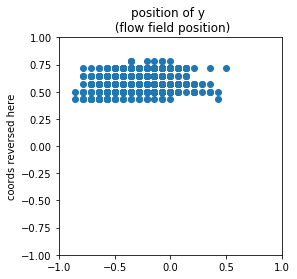

In [15]:
plt.figure(figsize=(4,4));
plt.scatter(y.view(-1,2)[:,0].tolist(), 
            y.view(-1,2)[:,1].mul(-1).tolist())
plt.ylim(-1,1);
plt.xlim(-1,1);
plt.ylabel('coords reversed here')
plt.title('position of y \n (flow field position)');

In [16]:
print('TopLeft / Bottom Right points in FlowField coords:')
(y.view(-1,2).min(dim=0).values, 
 y.view(-1,2).max(dim=0).values)

TopLeft / Bottom Right points in FlowField coords:


(tensor([-0.8571, -0.7857]), tensor([ 0.5000, -0.4286]))

### Modelling - Poor Results

epoch,train_loss,valid_loss,mse,time
0,3.836519,1.135713,1.135713,00:05


epoch,train_loss,valid_loss,mse,time
0,4.268454,0.413659,0.413659,00:05


epoch,train_loss,valid_loss,mse,time
0,3.759442,1.217018,1.217018,00:05


epoch,train_loss,valid_loss,mse,time
0,3.726576,0.497016,0.497016,00:05


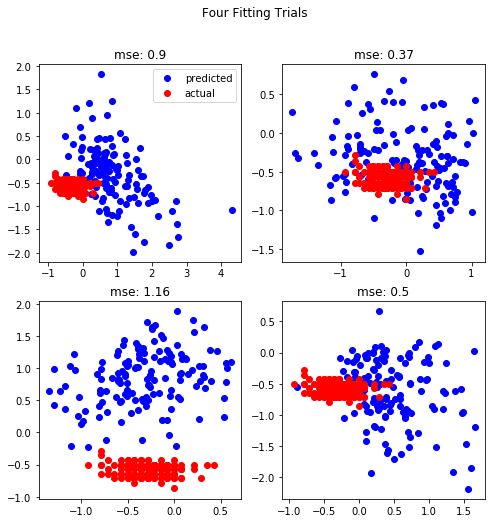

In [17]:
fig, ax = plt.subplots(2,2,figsize=(8,8))
axr = ax.ravel()
for i in range(4):
    
    learn = cnn_learner(dls, xresnet18, pretrained=True, metrics=[mse])
    learn.fit(1)
    
    preds = learn.get_preds(with_loss=True)
    
    axr[i].scatter(preds[0][:, 0], preds[0][:, 1], c='b')
    axr[i].scatter(preds[1].view(-1,2)[:, 0], preds[1].view(-1,2)[:, 1], c='r')
    axr[i].set_title(f'mse: {round(learn.loss.mean().tolist(),2)}')
    if i == 0:
        axr[i].legend(['predicted', 'actual']);
    
fig.suptitle('Four Fitting Trials');

##### Note: the change in color channels soerced by the learner

In [18]:
postlearn_b = dls.one_batch()

prelearn_b[0].shape, postlearn_b[0].shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 3, 28, 28]))

### Correct with `y_range`?
That fixes that problem

epoch,train_loss,valid_loss,mse,time
0,0.581135,0.087292,0.087292,00:05


epoch,train_loss,valid_loss,mse,time
0,0.584581,0.153209,0.153209,00:05


epoch,train_loss,valid_loss,mse,time
0,0.574831,0.096325,0.096325,00:05


epoch,train_loss,valid_loss,mse,time
0,0.573057,0.219011,0.219011,00:05


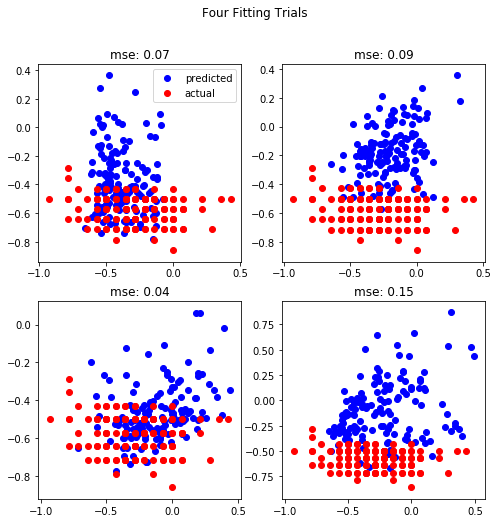

In [23]:
fig, ax = plt.subplots(2,2,figsize=(8,8))
axr = ax.ravel()
for i in range(4):
    
    learn = cnn_learner(dls, resnet18, pretrained=True, metrics=[mse], y_range=(-1.,1.))
    learn.fit(1)
    
    preds = learn.get_preds(with_loss=True)
    
    axr[i].scatter(preds[0][:, 0], preds[0][:, 1], c='b')
    axr[i].scatter(preds[1].view(-1,2)[:, 0], preds[1].view(-1,2)[:, 1], c='r')
    axr[i].set_title(f'mse: {round(learn.loss.mean().tolist(),2)}')
    if i == 0:
        axr[i].legend(['predicted', 'actual']);
    
fig.suptitle('Four Fitting Trials');

### Baseline Error
It's mse=0.0372, which is below any model fit so far.

In [31]:
y = torch.tensor([])
for _x, _y in dls.train:
    y = torch.cat((y,_y), dim=0)

yhat = y.mean(dim=1).mean(dim=0)
yhat

yhat_vec = torch.tensor([[yhat.tolist()] for _ in range(len(y))])

mse(yhat_vec, y)

tensor(0.0372)

In [32]:
# calc mse manually here; it matches
resid = yhat_vec - y

resid_sq = resid**2

mean_resid_sq = resid_sq.mean(dim=1).mean(dim=0)

mean_resid_sq.mean()

tensor(0.0372)

### New Experiments

In [33]:
learn = cnn_learner(dls, 
                    resnet18, 
                    pretrained=True, 
                    metrics=[mse],
                    y_range=(-1.,1.),
                   )

In [34]:
# learn.lr_find()

In [41]:
# !ls *.csv

In [39]:
# pd.read_csv('history.csv')

,epoch,train_loss,valid_loss,mse,time
0,0,0.353097,0.207462,0.207462,00:12
1,1,0.358059,0.210595,0.210595,00:10
2,2,0.338793,0.150023,0.150023,00:09
3,3,0.313649,0.139886,0.139886,00:10
4,4,0.295009,0.118921,0.118921,00:10


In [37]:
learn.fine_tune(5, cbs=CSVLogger())

epoch,train_loss,valid_loss,mse,time
0,0.391330,0.192454,0.192454,00:15


epoch,train_loss,valid_loss,mse,time
0,0.353097,0.207462,0.207462,00:12
1,0.358059,0.210595,0.210595,00:10
2,0.338793,0.150023,0.150023,00:09
3,0.313649,0.139886,0.139886,00:10
4,0.295009,0.118921,0.118921,00:10


In [42]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,mse,time
0,0.248188,0.126374,0.126374,00:06


epoch,train_loss,valid_loss,mse,time
0,0.219810,0.106812,0.106812,00:09
1,0.215641,0.097269,0.097269,00:09
2,0.211937,0.087941,0.087941,00:09
3,0.201904,0.066495,0.066495,00:09
4,0.185810,0.076004,0.076004,00:09
5,0.172033,0.059434,0.059434,00:09
6,0.161910,0.052391,0.052391,00:09
7,0.152938,0.047003,0.047003,00:09
8,0.142705,0.045388,0.045388,00:09
9,0.132845,0.045350,0.045350,00:09


In [43]:
preds = learn.get_preds(with_loss=True)
mse(preds[0], preds[1])

tensor(0.0454)

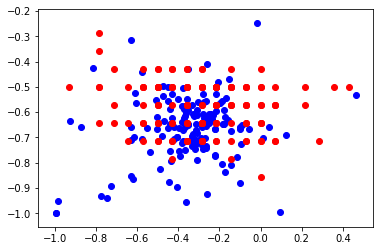

In [45]:
plt.scatter(preds[0][:, 0], preds[0][:, 1], c='b')
plt.scatter(preds[1].view(-1,2)[:, 0], preds[1].view(-1,2)[:, 1], c='r')

In [46]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,mse,time
0,0.102143,0.044351,0.044351,00:07


epoch,train_loss,valid_loss,mse,time
0,0.087248,0.039285,0.039285,00:09
1,0.086070,0.041610,0.041610,00:09
2,0.085308,0.049523,0.049523,00:09
3,0.082520,0.052015,0.052015,00:09
4,0.082515,0.044720,0.044720,00:09
5,0.077991,0.044806,0.044806,00:09
6,0.075095,0.042574,0.042574,00:09
7,0.072618,0.035399,0.035399,00:09
8,0.068342,0.034460,0.034460,00:09
9,0.067256,0.033670,0.033670,00:09


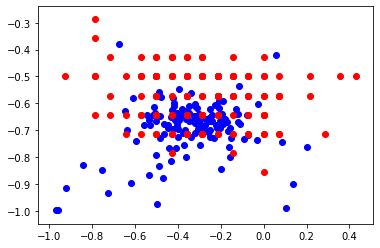

In [48]:
preds = learn.get_preds(with_loss=True)
plt.scatter(preds[0][:, 0], preds[0][:, 1], c='b')
plt.scatter(preds[1].view(-1,2)[:, 0], preds[1].view(-1,2)[:, 1], c='r')

In [49]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,mse,time
0,0.058856,0.030073,0.030073,00:06


epoch,train_loss,valid_loss,mse,time
0,0.056350,0.031775,0.031775,00:09
1,0.057011,0.035333,0.035333,00:09
2,0.052703,0.028722,0.028722,00:09
3,0.052448,0.028551,0.028551,00:09
4,0.050101,0.030714,0.030714,00:10
5,0.048339,0.027071,0.027071,00:09
6,0.046764,0.026960,0.026960,00:09
7,0.044380,0.025514,0.025514,00:09
8,0.043236,0.025417,0.025417,00:10
9,0.041373,0.024333,0.024333,00:09


##### Model is Now Working!

Text(0.5, 0.98, 'red:actual | green:predicted')

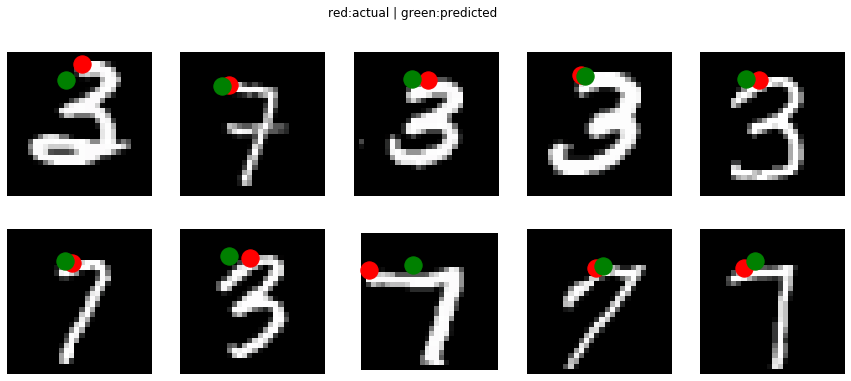

In [60]:
preds = learn.get_preds(with_input=True, with_decoded=True, )

decode_batch = dls.decode_batch(dls.valid.one_batch(), max_n=10)

decode_preds = dls.decode_batch((preds[0], preds[1]), max_n=10)

rows, cols = 2,5
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols,3*rows))
axr = ax.ravel()

for i in range(rows*cols):

    decode_batch[i][0].show(ctx=axr[i])
    decode_batch[i][1].show(ctx=axr[i], s=300, marker='o', c='red')
    decode_preds[i][1].show(ctx=axr[i], s=300, marker='o', c='green')

fig.suptitle('red:actual | green:predicted')

In [61]:
learn.fine_tune(20)

epoch,train_loss,valid_loss,mse,time
0,0.042776,0.025483,0.025483,00:06


epoch,train_loss,valid_loss,mse,time
0,0.036964,0.021358,0.021358,00:09
1,0.032927,0.020312,0.020312,00:09
2,0.032805,0.020429,0.020429,00:09
3,0.032602,0.021336,0.021336,00:09
4,0.032435,0.019979,0.019979,00:09
5,0.032081,0.021475,0.021475,00:09
6,0.031136,0.024264,0.024264,00:09
7,0.030990,0.023130,0.023130,00:09
8,0.030939,0.023451,0.023451,00:09
9,0.030483,0.024179,0.024179,00:09


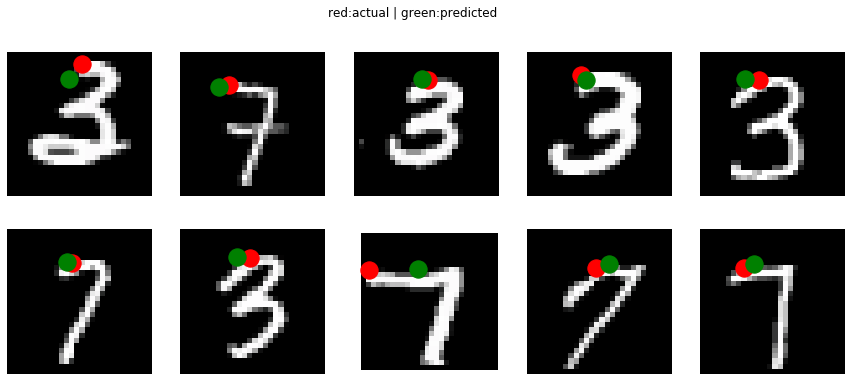

In [62]:
preds = learn.get_preds(with_input=True, with_decoded=True, )

decode_batch = dls.decode_batch(dls.valid.one_batch(), max_n=10)

decode_preds = dls.decode_batch((preds[0], preds[1]), max_n=10)

rows, cols = 2,5
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols,3*rows))
axr = ax.ravel()

for i in range(rows*cols):

    decode_batch[i][0].show(ctx=axr[i])
    decode_batch[i][1].show(ctx=axr[i], s=300, marker='o', c='red')
    decode_preds[i][1].show(ctx=axr[i], s=300, marker='o', c='green')

fig.suptitle('red:actual | green:predicted');

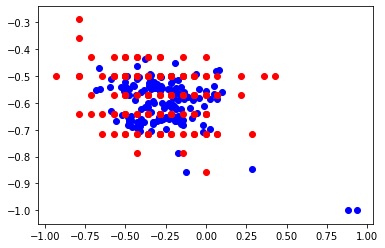

In [63]:
preds = learn.get_preds(with_loss=True)
plt.scatter(preds[0][:, 0], preds[0][:, 1], c='b')
plt.scatter(preds[1].view(-1,2)[:, 0], preds[1].view(-1,2)[:, 1], c='r')

In [ ]:
preds = learn.get_preds(with_loss=True)

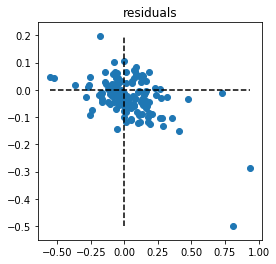

In [89]:
resids = preds[0] - preds[1].view(-1,2)
resids_x = resids.view(-1,2)[:,0]
resids_y = resids.view(-1,2)[:,1]

plt.figure(figsize=(4,4))
plt.scatter(resids_x, resids_y);

plt.vlines(0, min(resids_y), max(resids_y), linestyle='--');
plt.hlines(0, min(resids_x), max(resids_x), linestyle='--');

plt.title('residuals');

In [ ]:
resids_sq = (resids**2).sum(dim=1)
plt.hist(resids_sq.tolist());
plt.title('Histogram of Losses');

In [98]:
tmp = sorted(list(enumerate(preds[2].tolist())), key=lambda x: x[1], reverse=True)
top_losses_index = [e[0] for e in tmp[:10]]
top_losses_index

[46, 109, 7, 82, 20, 15, 53, 61, 121, 73]

In [112]:
dls.bs = len(preds[0])

In [113]:
dls.bs

141

In [128]:
decode_preds[0][0].shape

torch.Size([3, 141, 2])

In [114]:
decode_batch = dls.decode_batch(dls.valid.one_batch(), max_n=len(preds[0]))

decode_preds = dls.decode_batch((preds[0], preds[1]), max_n=len(preds[0]))

In [115]:
len(decode_batch)

64

In [110]:
decode_batch[46]

(TensorImageBW([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]),
 TensorPoint([[14.0000,  4.0000]]))

In [122]:
len(decode_preds[0][0])

3

In [119]:
decode_preds[46][1]

IndexError: list index out of range

IndexError: list index out of range

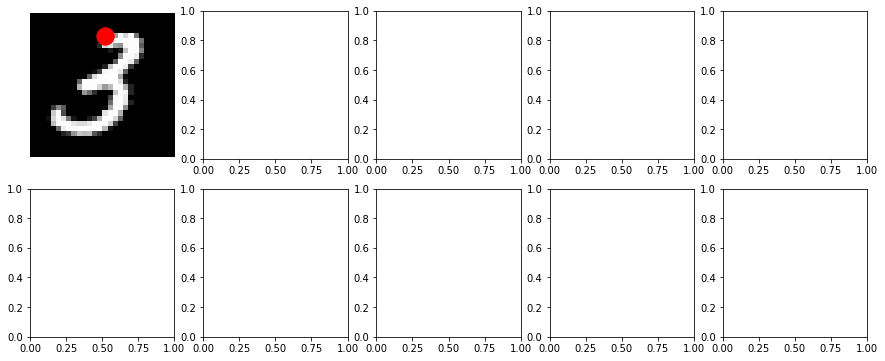

In [117]:
rows, cols = 2,5
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols,3*rows))
axr = ax.ravel()

for i, ind in enumerate(top_losses_index):

    decode_batch[ind][0].show(ctx=axr[i])
    decode_batch[ind][1].show(ctx=axr[i], s=300, marker='o', c='red')
    decode_preds[ind][1].show(ctx=axr[i], s=300, marker='o', c='green')

fig.suptitle('red:actual | green:predicted');